# BE/Bi 103, Fall 2016: Homework 2

## Due 1pm, Sunday, October 9

(c) 2016 Justin Bois. Problem 2.2 is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT). Problem 2.1 may not be shared.

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw2_solutions.ipynb).*

In [20]:
import numpy as np
import pandas as pd
import scipy.special
import scipy.stats as st

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Some pretty Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline
%matplotlib inline

### Problem 2.1 (A temperature controlled Gal4-UAS system, 20 pts)

*This problem contains unpublished results. Please do not discuss or redistribute outside of class.*

One of the students in the class, Han Wang from the Sternberg lab, is working on an imporoved [Gal4/UAS system](https://en.wikipedia.org/wiki/GAL4/UAS_system) in *C. elegans*. Briefly, the Gal4-UAS system was hijacked from budding yeast and incorporated into the genomes of other organisms, *Drosophila* being first. The idea is to insert the Gal4 gene into the genome such that it is under control of a driver that is native to the organism. When Gal4 is expressed, it binds to UAS (upstream activation sequence) and it is activating, leading to expression of the UAS target gene.

Han is using the system with UAS activating production of green fluorescent protein (GFP). The Gal4 production is driven by Pmyo-2, which is only expressed in the pharynx of the worm.

The Gal4/UAS system typically works only at high temperatures. This does not work as well in worms that are stored at lower temperatures. Han therefore has been engineering "cool" Gal4, which will work at lower temperatures. To test how they are working, he measures the GFP flourescent signal in the pharynx of worms.

He generously donated his data set for us to work with. He sent me a MS Excel file with the data, along with some comments via email. Here is what he said about the data set:

>SC (orignal Gal4)

>SK (cool Gal4)

>m3 Pmyo-3::GFP fusion (control; measure of driver expression)

>15 20 and 25 at the end for the name of each column shows the experimental temperature.

You can download the MS Excel file [here](../data/han_wang_gal4_temperature.xlsx).

**a)** Load the data into a Pandas `DataFrame` using `pd.read_excel()`. That's right, Pandas can read Excel files! You might want to read the Pandas documentation to see how it works.

**b)** Tidy the `DataFrame`. Be sure to remove any NaNs.

**c)** Do some exploratory data analysis of the data set. That is, make some instructive plots. What can you say about Han's cool Gal4 just by looking at the plots?

## Problem 2.1 solution

**a)** First, we'll read the data into a `DataFrame`. It turns out that we can just directly use `pd.read_excel()` without any kwargs.

In [123]:
# Read in DataFrame
df = pd.read_excel('../data/han_wang_gal4_temperature.xlsx')

# Take a look
df.head()

,sc15,sc20,sc25,sk15,sk20,sk25,m315,m320,m325
0,1298.547,2737.135,16499.30,8978.031,14251.97,16593.960,20722.62,11703.01,17073.800
1,6798.146,12185.360,12672.19,11221.130,13616.94,6910.673,10373.52,17025.58,15379.370
2,10686.910,1532.901,15832.53,9460.200,17474.90,20934.660,21707.12,17499.83,16991.490
3,2018.864,2357.752,15065.03,9049.072,16042.57,18042.750,21750.27,15657.50,13393.350
4,1551.396,1888.596,16960.67,14132.810,12867.40,23189.560,20820.26,11383.33,7709.297


**b)** To tidy the `DataFrame`, we need to convert the column headings to two columns. First is the strain of worm, the choices being `'sc'`, `'sk'`, or `'m3'`. Second is the temperature in degrees Celsius, the choices being `15`, `20`, or `25`. We can use the `str.rstrip()` and `str.lstrip()` methods to get the strains and temperatures.

In [74]:
# Strip out temperatures from column headings to get strains
strains = df.columns.str.rstrip('0125')

# Strip out strain, leaving temperatures
temps = df.columns.str.lstrip('sckm3').astype(int)

# Take a look
strains, temps

(Index(['sc', 'sc', 'sc', 'sk', 'sk', 'sk', 'm3', 'm3', 'm3'], dtype='object'),
 Int64Index([15, 20, 25, 15, 20, 25, 15, 20, 25], dtype='int64'))

Now, we'll build a `MultiIndex` for the `DataFrame`.

In [75]:
# Re-index columns with MultiIndex
df.columns = pd.MultiIndex.from_arrays((strains, temps), 
                                        names=['strain', 'temperature'])

# Check out the new DataFrame
df.head()

strain              sc                              sk                       \
temperature         15         20        25         15        20         25   
0             1298.547   2737.135  16499.30   8978.031  14251.97  16593.960   
1             6798.146  12185.360  12672.19  11221.130  13616.94   6910.673   
2            10686.910   1532.901  15832.53   9460.200  17474.90  20934.660   
3             2018.864   2357.752  15065.03   9049.072  16042.57  18042.750   
4             1551.396   1888.596  16960.67  14132.810  12867.40  23189.560   

strain             m3                       
temperature        15        20         25  
0            20722.62  11703.01  17073.800  
1            10373.52  17025.58  15379.370  
2            21707.12  17499.83  16991.490  
3            21750.27  15657.50  13393.350  
4            20820.26  11383.33   7709.297

Now it's ready for melting! The value of the measured quantity each time is `'GFP_intensity'`.

In [76]:
# Melt to make it tidy
df = pd.melt(df, value_name='GFP_intensity')

# Check it out
df.head()

,strain,temperature,GFP_intensity
0,sc,15,1298.547
1,sc,15,6798.146
2,sc,15,10686.910
3,sc,15,2018.864
4,sc,15,1551.396


Perfect. Now that we have a tidy `DataFrame`, we can start making instructive plots.

**c)** We'll start with a swarm plots at different temperatures.

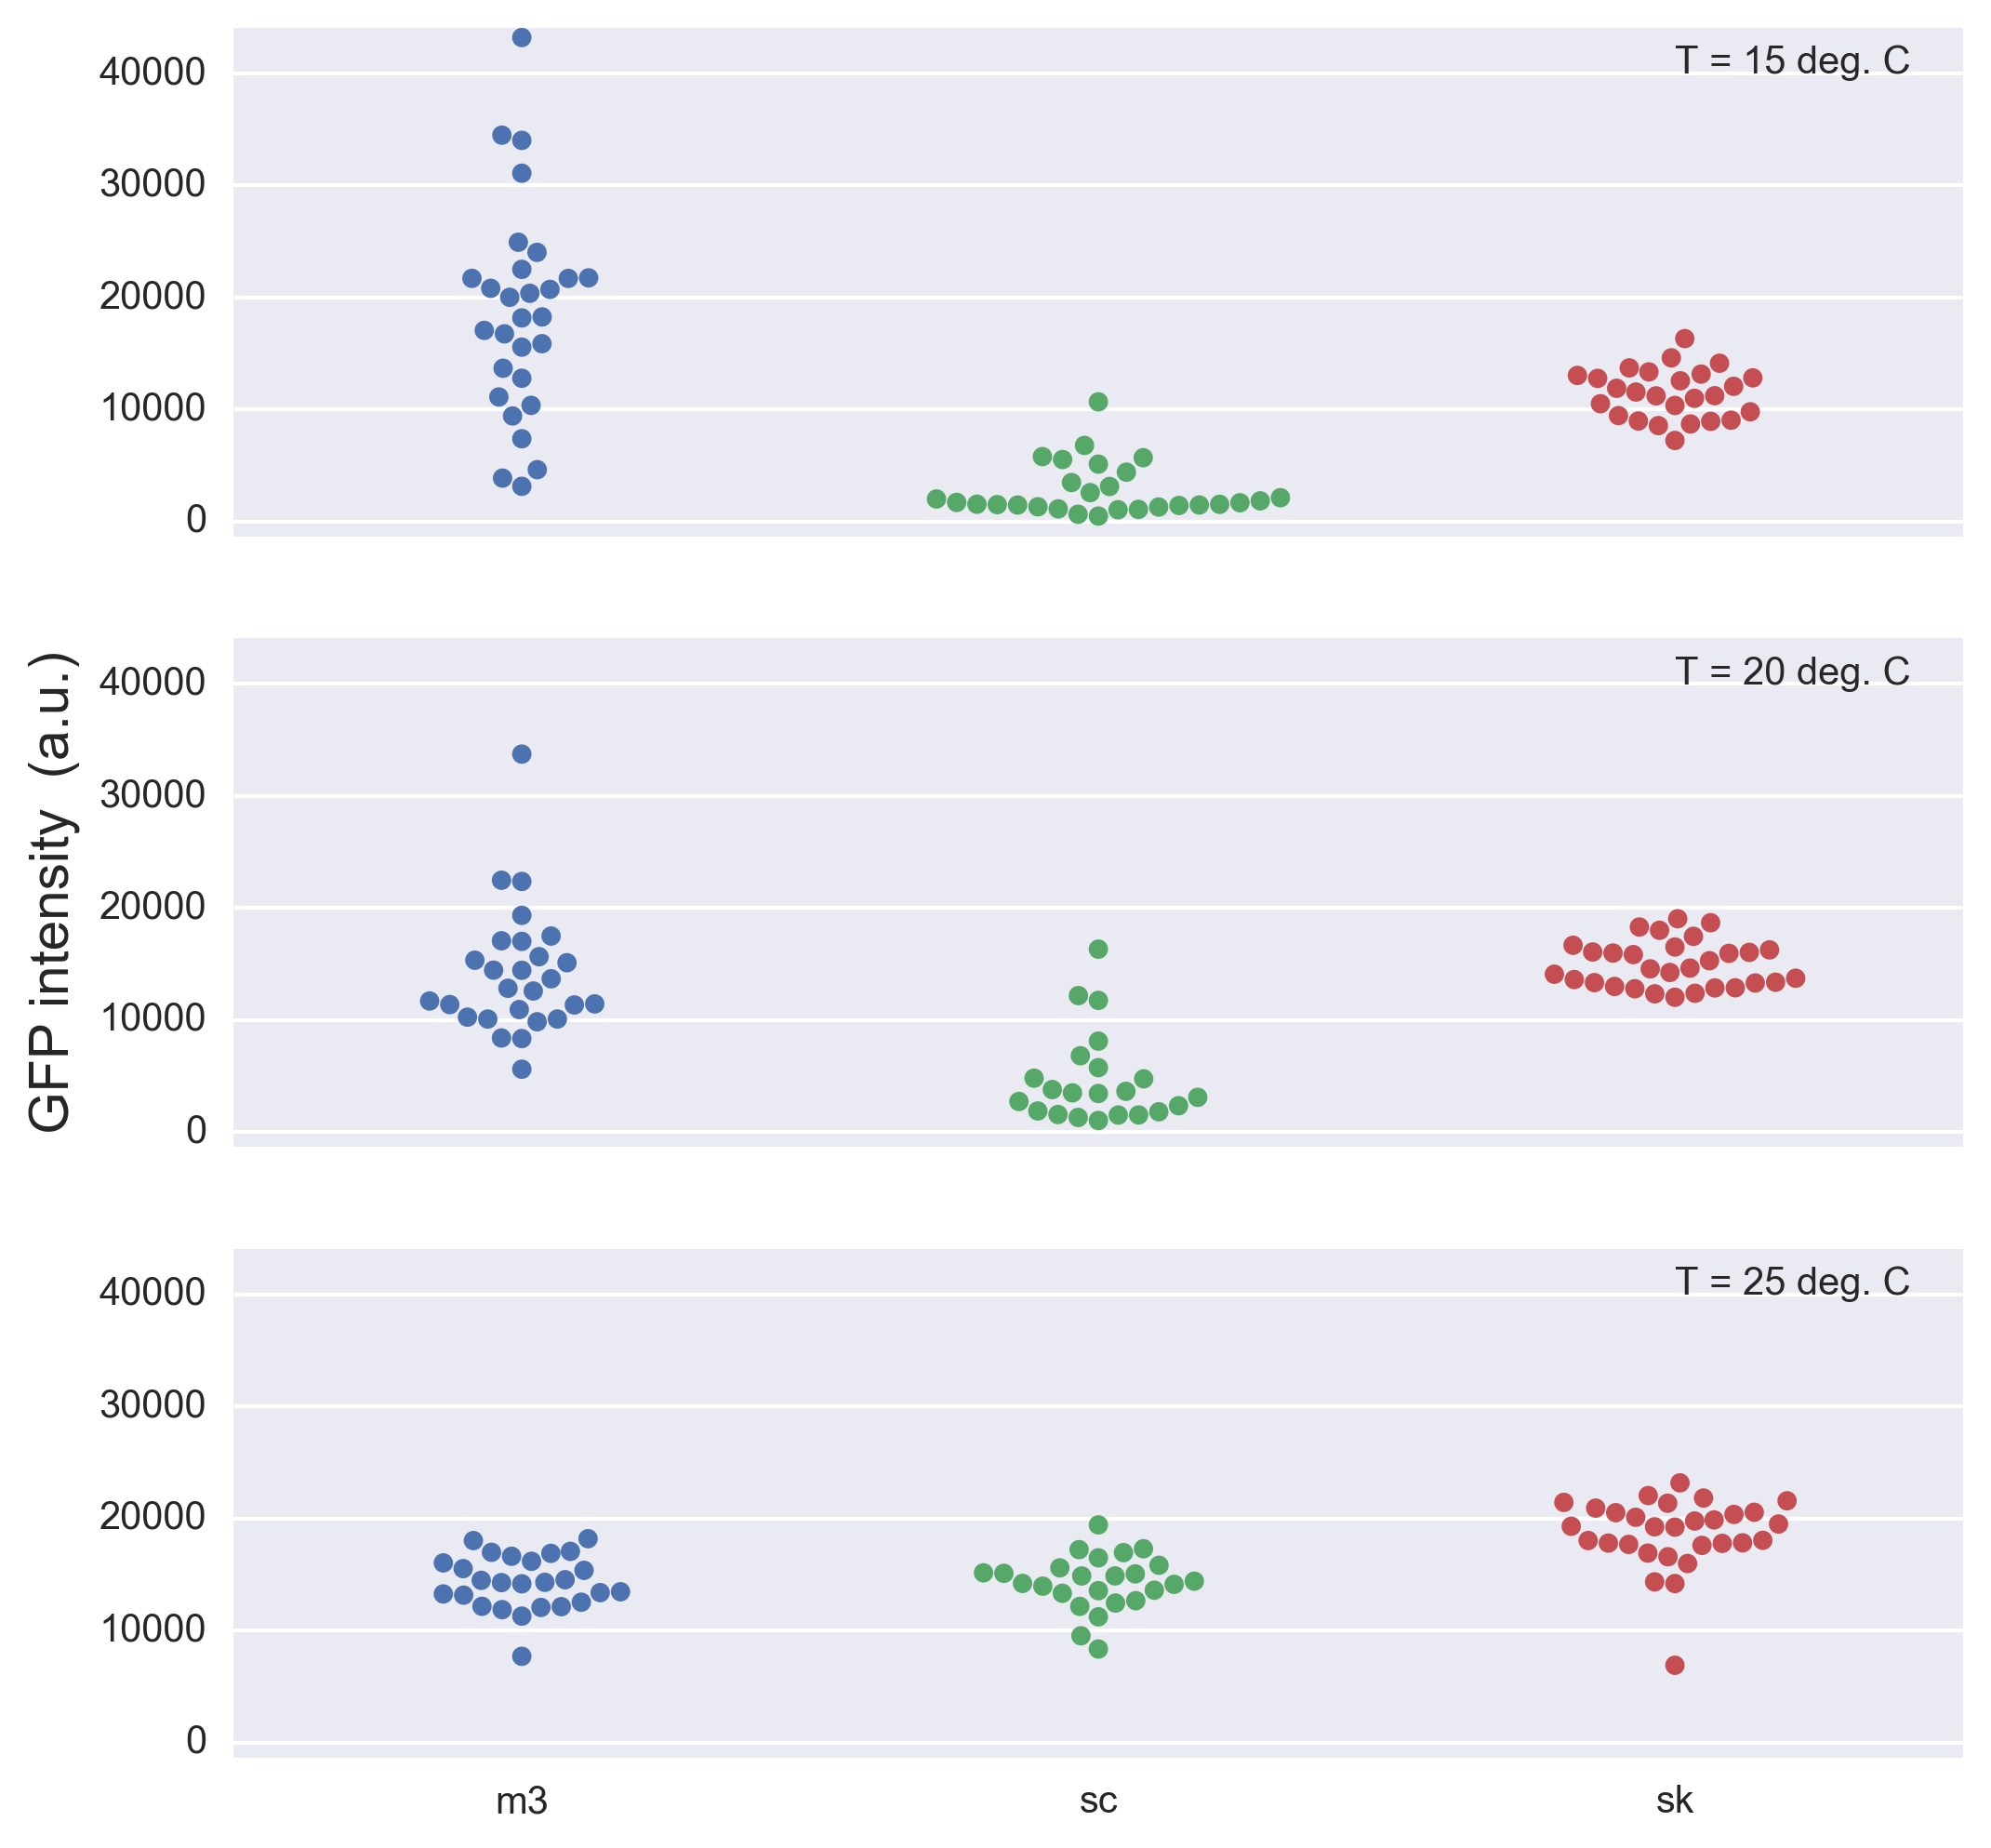

In [101]:
fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True, sharey=True)

# Make plots
sns.swarmplot(data=df[df.temperature==15], x='strain', y='GFP_intensity', 
              order=['m3', 'sc', 'sk'], ax=ax[0])
sns.swarmplot(data=df[df.temperature==20], x='strain', y='GFP_intensity', 
              order=['m3', 'sc', 'sk'], ax=ax[1])
sns.swarmplot(data=df[df.temperature==25], x='strain', y='GFP_intensity', 
              order=['m3', 'sc', 'sk'], ax=ax[2])
plt.margins(y=0.02)

# Tidy up labels
ax[0].set_ylabel('')
ax[1].set_ylabel('GFP intensity  (a.u.)')
ax[2].set_ylabel('')
for i in [0, 1, 2]:
    ax[i].set_xlabel('')

# Add text labeling plots
ax[0].text(2, 40000, 'T = 15 deg. C')
ax[1].text(2, 40000, 'T = 20 deg. C')
ax[2].text(2, 40000, 'T = 25 deg. C');

Just by looking, the cool Gal4 (sk) nearly matches the fluorescence level of the driver GFP fusion at all temperatures, while the standard Gal4 only does so at 25 deg. C.

There are other ways we could display the swarm plot to get all data on one plot. We could sort by strain and then use the hue to indicate the temperature.

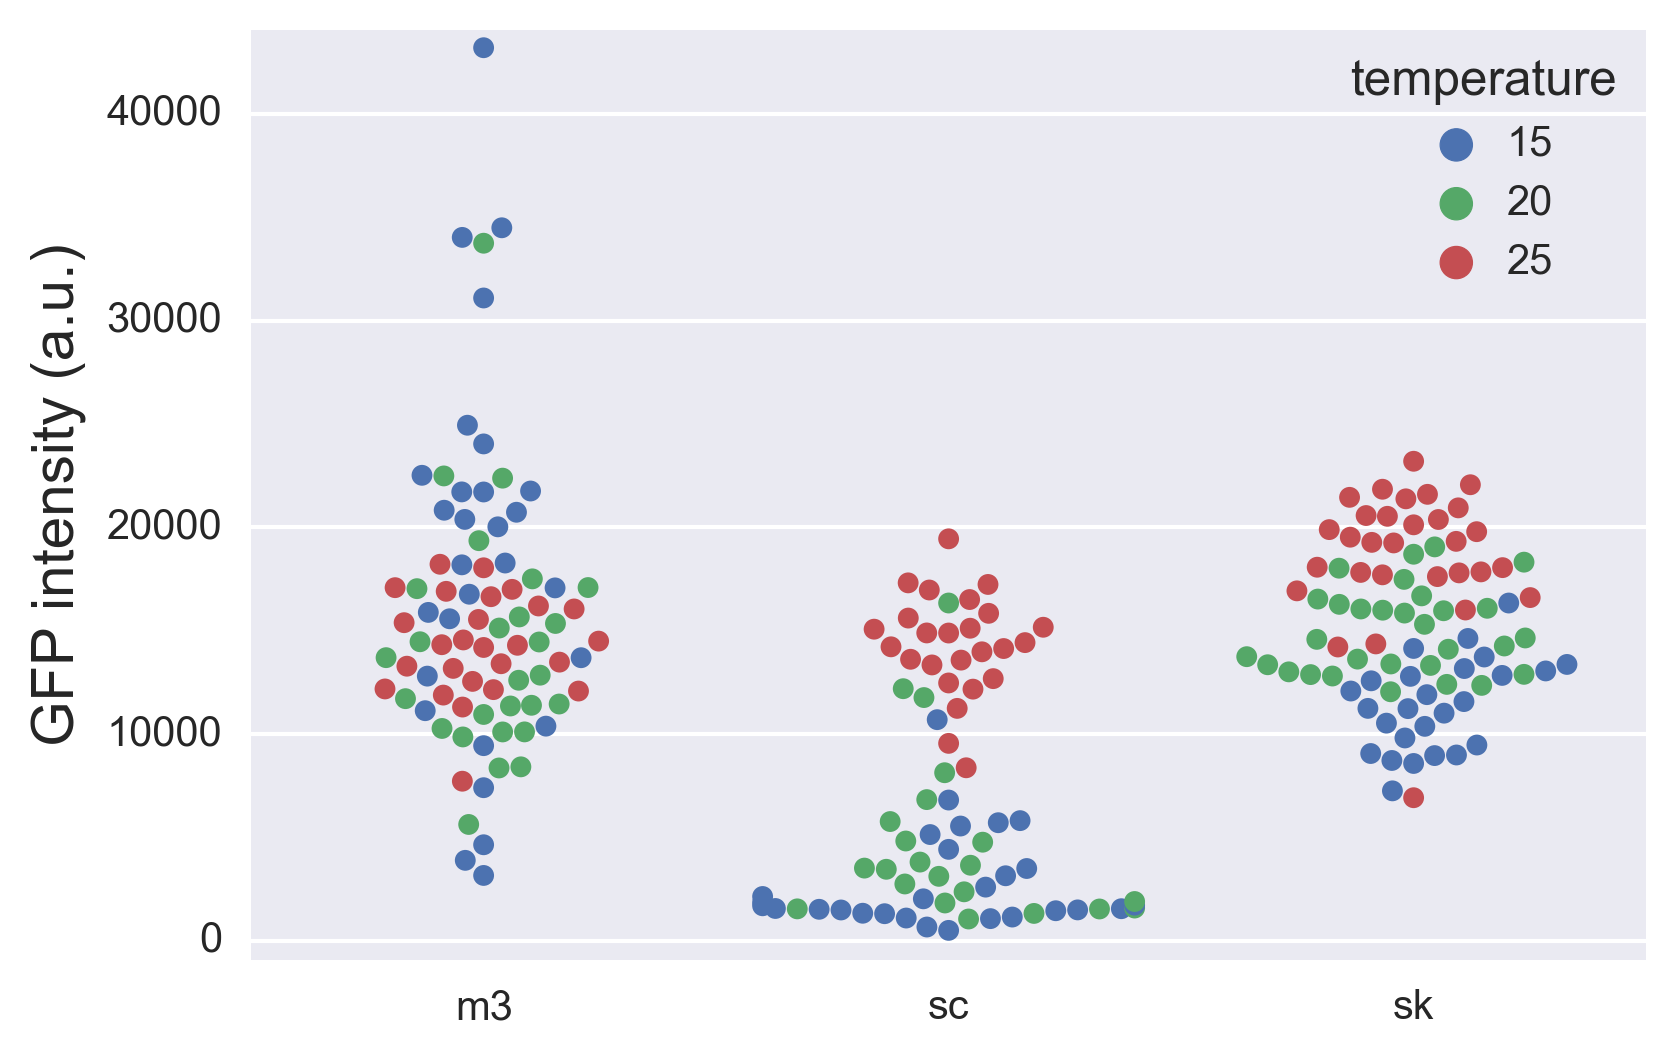

In [100]:
# Make swarm plot hued with temperature
sns.swarmplot(data=df, x='strain', y='GFP_intensity', hue='temperature',
              order=['m3', 'sc', 'sk'])
plt.xlabel('')
plt.ylabel('GFP intensity (a.u.)')
plt.margins(y=0.02)

This is somewhat instructive in that we see clearly that the driver operates more or less independently of temperature, but the Gal4 system is temperature sensitive, operating better at high temperatures. It is still also clear that the "cool" mutant (sk) outperforms the classic system (sc) at cool temperatures.

Another option is to plot nine swarms, one for each of the strain/temperature combinations. To do that, we make another column of the `DataFrame` that has tuples containing the strain and temperature.

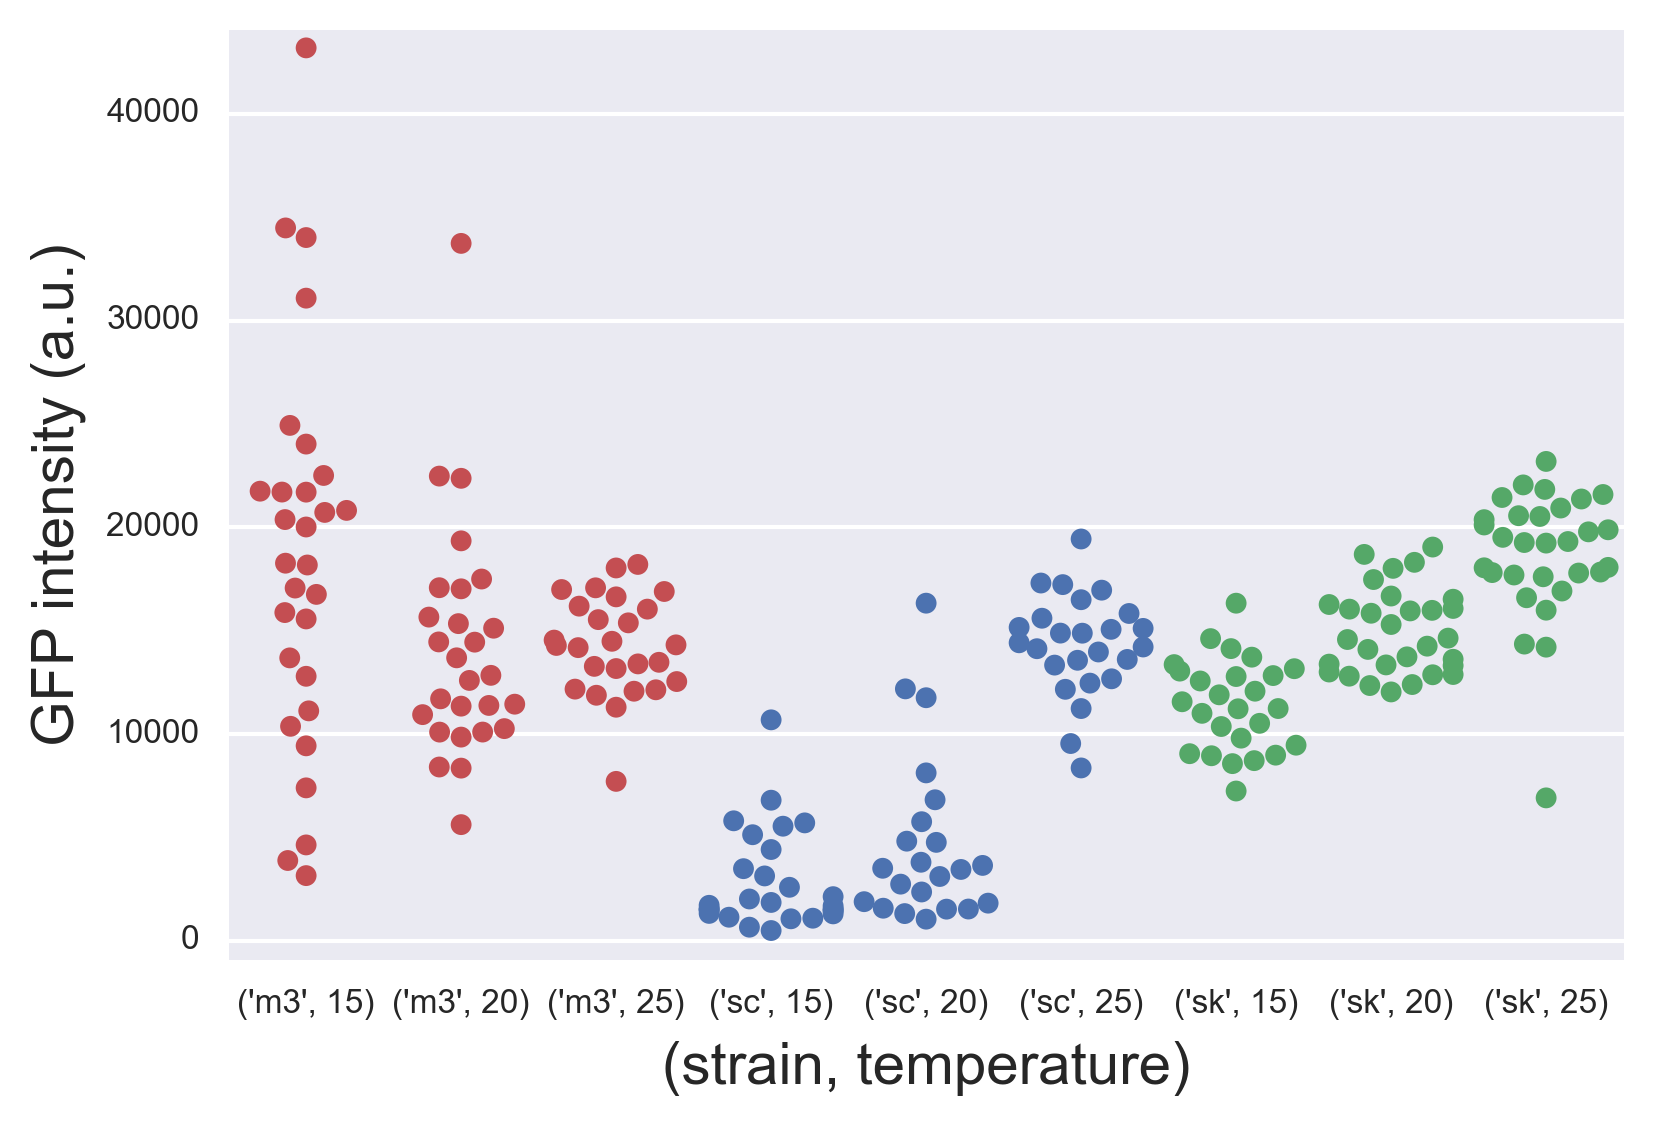

In [118]:
# Make columen with strain and temnperature
df['strain_temp'] = list(zip(df['strain'], df['temperature']))

# Ordering in plot
order = [('m3', 15), ('m3', 20), ('m3', 25), 
         ('sc', 15), ('sc', 20), ('sc', 25), 
         ('sk', 15), ('sk', 20), ('sk', 25)]

# Make, label, and tidy plot
ax = sns.swarmplot(data=df, x='strain_temp', y='GFP_intensity', order=order, 
                   hue='strain')
plt.margins(y=0.02)
plt.xlabel('(strain, temperature)')
plt.ylabel('GFP intensity (a.u.)')
plt.gca().legend_.remove()
ax.tick_params(axis='both', which='major', labelsize=8)

Again, we draw the same conclusions. The cool Gal4 system at 15 deg. C matches the performance of the classic Gal4 system at its optimal temperature of 25 deg. C.

Now, this plot is getting a little crowded, so we might try a jitter plot.

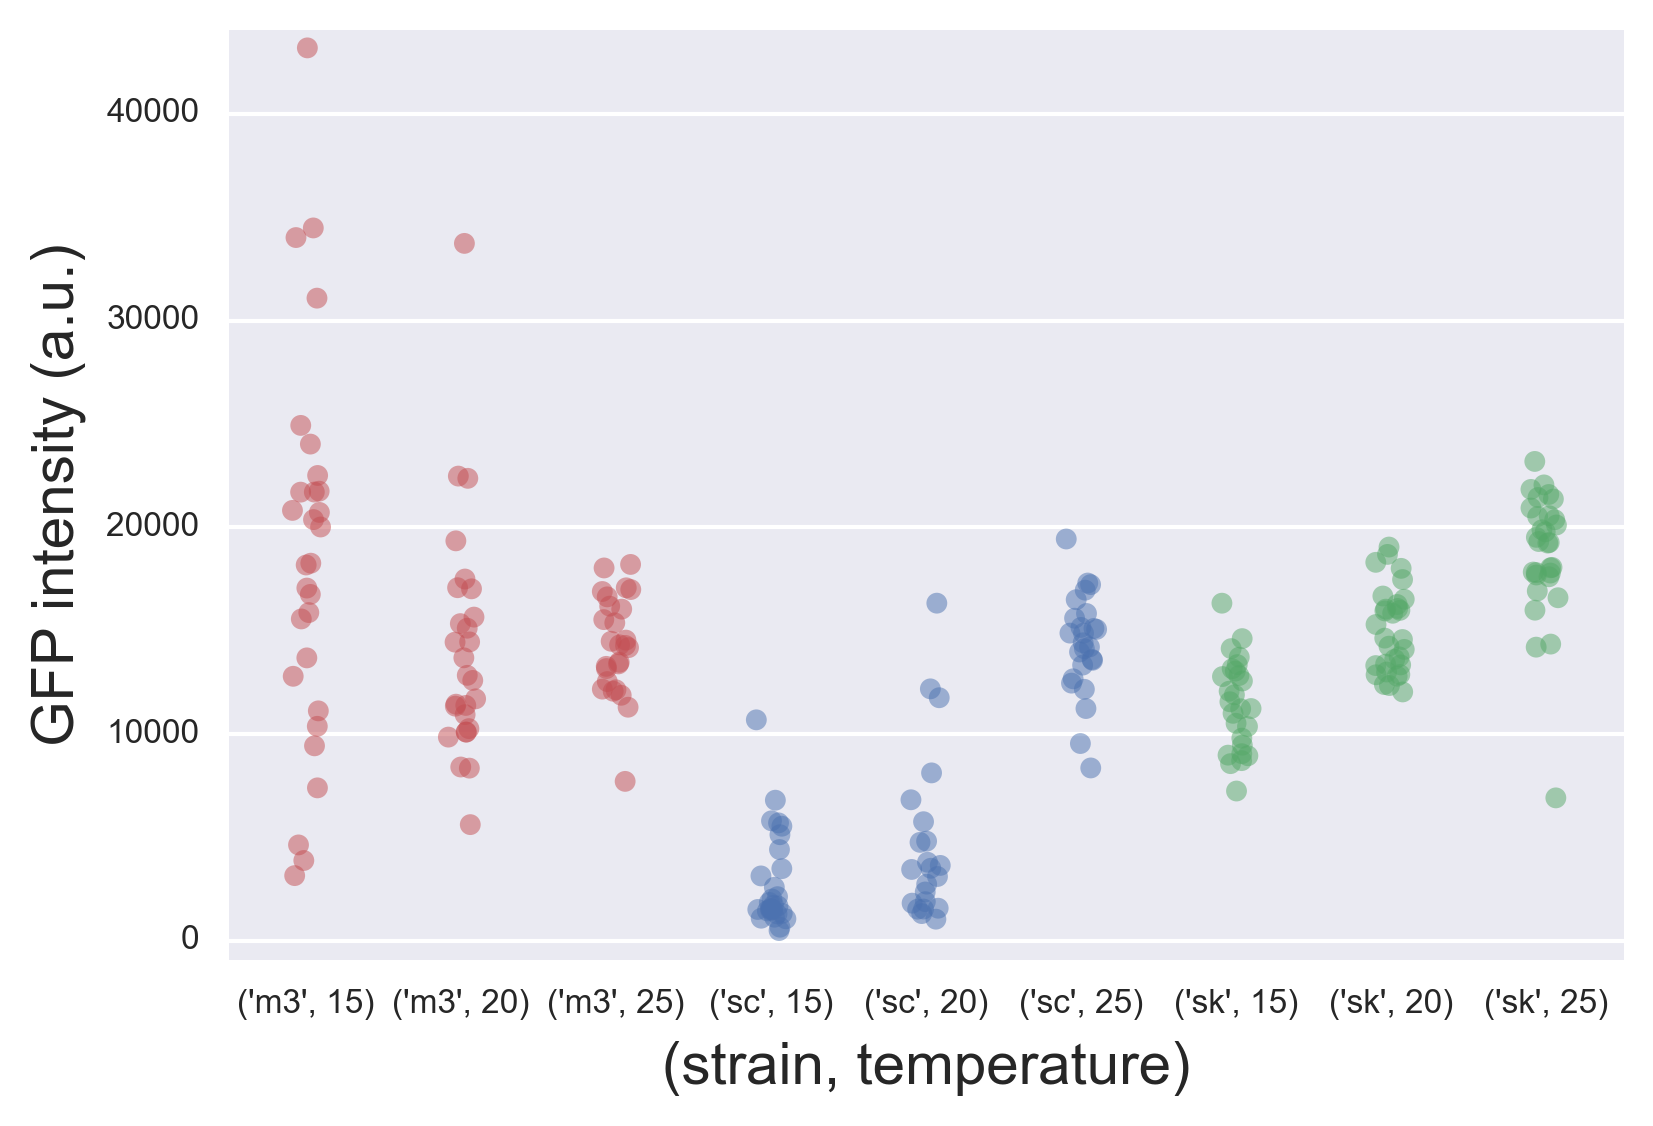

In [119]:
# Make, label, and tidy plot
ax = sns.stripplot(data=df, x='strain_temp', y='GFP_intensity', jitter=True,
                   order=order, alpha=0.5, hue='strain')
plt.margins(y=0.02)
plt.xlabel('(strain, temperature)')
plt.ylabel('GFP intensity (a.u.)')
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().legend_.remove()

Finally, we could try a box plot.

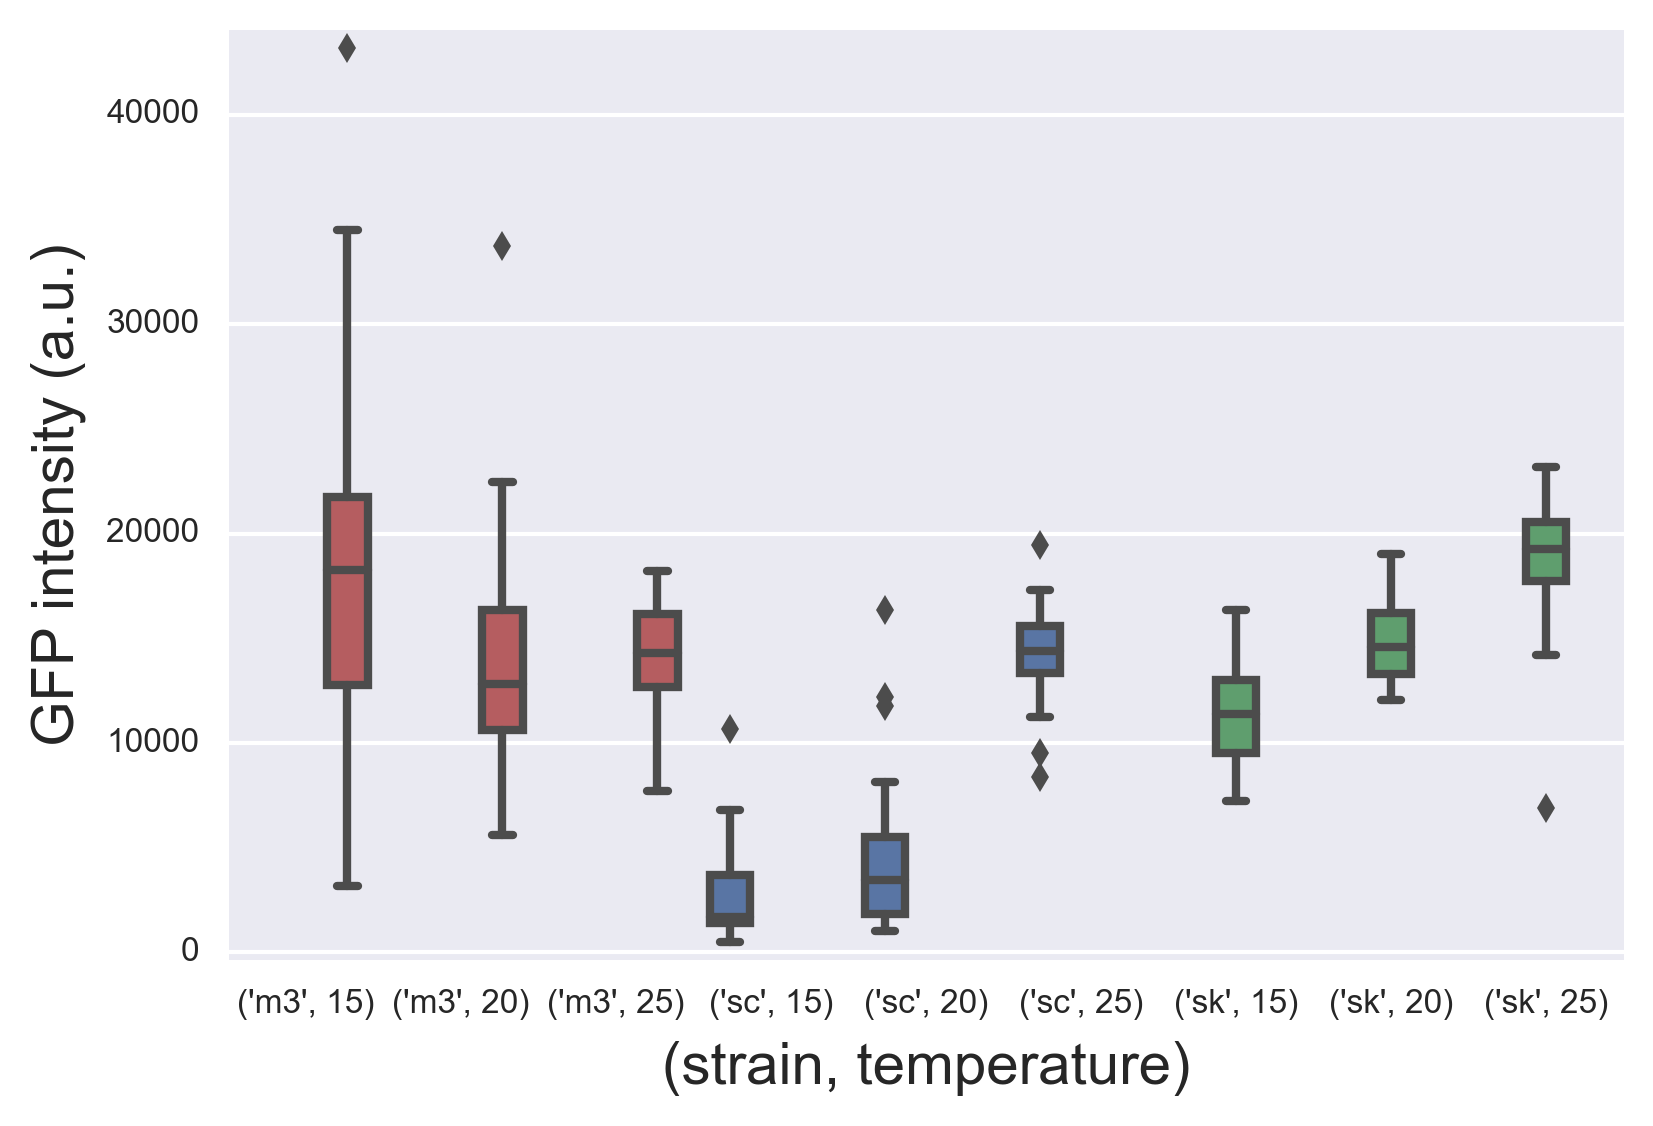

In [122]:
# Make, label, and tidy plot
ax = sns.boxplot(data=df, x='strain_temp', y='GFP_intensity', order=order,
                 hue='strain')
plt.margins(y=0.02)
plt.xlabel('(strain, temperature)')
plt.ylabel('GFP intensity (a.u.)')
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().legend_.remove()

<br/>

### Problem 2.2 (Exploring fish sleep data, 80 pts) 

In [Tutorial 2](../tutorials/t2b_defining_and_estimating_parameters.html), we investigated sleeping states of zebrafish larvae.  We had a discussion about what are the best metrics for a sleepful versus waking states based on the one-minute interval activity data we have.  I think we agreed that it is far from obvious how to define a sleepful state.  In this problem, you will work with your group to come up with some good ways to parametrize sleep behavior and estimate the values of these parameters.

Choose two different ways to parametrize sleeping vs. wakeful states.  You can use sleep metrics from the [Prober, et al. paper](../protected/papers/prober_2006.pdf), ones we discussed in [Tutorial 2](../tutorials/t2b_defining_and_estimating_parameters.html), or invent your own.  For each of the ways of parametrizing sleep, provide instructive plots and estimate the values of the parameters.  Compare the relative strengths and weaknesses of the sleep metrics you propose and give a discussion on which parametrization(s) you prefer.

### Problem 2.2 solution

There are many possible approaches to parametrize sleeping versus wakeful states.  Importantly, you should give good justification for your choices and provide meaningful discussion comparing the different methods.

An approach I favor is considering the full distribution of rest/active bout lengths.   I will apply this approach to the data for the last complete night of the experiment. Let's compute the bout lengths as in [Tutorial 2b](../tutorials/t2b_defining_and_estimating_parameters.html).  First, we need our function for computing bout lengths.

In [24]:
def bout_lengths(s, wake_threshold=1e-5, rest=True):
    """
    Given activity series s, returns length of rest bouts / length
    of active_bouts if rest is True/False.
    
    First return value is array of rest bout lengths and second return
    value is array of active bout lengths.
    
    The first/last "bouts" are not included because we don't know where
    they begin/end.  The exception is if the fish is always awake or
    asleep.
    """
    # Get Boolean for activeness
    active = (s > wake_threshold)
    
    # Convert to NumPy array if a Pandas Series
    if type(active) is pd.core.series.Series:
        active = active.values
    
    # Check to make sure there is at least one switch
    if np.all(active):
        if rest:
            return np.array([])
        else:
            return np.array([len(s)])
    elif np.all(~active):
        if rest:
            return np.array([len(s)])
        else:
            return np.array([])
 
    # Use the NumPy diff function to find indices where switches states
    # switches[i] is the index of first time point in state it switched to
    switches = np.where(np.diff(active))[0] + 1
    
    # Compute bout lengths from switches, again using np.diff
    bouts = np.diff(switches)
    
    # Find out if active or rest was first and return bout lengths
    # Not most concise way to do it, but most legible
    if active[0]:
        if rest:
            return bouts[::2]
        else:
            return bouts[1::2]
    else:
        if rest:
            return bouts[1::2]
        else:
            return bouts[::2]

Now, we can load in the data and get our bout length distributions for the last full night.

In [59]:
# Load the DataFrame from Tutorial 2a.
df_genotype = pd.read_csv('../data/130315_genotypes.csv')
df = pd.read_csv('../data/130315_10_minute_intervals.csv')
df_dense = pd.read_csv('../data/130315_1_minute_intervals.csv')

# Set up an empty DataFrame with the columns we want.
df_rest_bout = pd.DataFrame(columns=['fish', 'genotype', 'rest_bout_length'])

# Loop through each fish, construct array or rest bouts, add to DataFrame
for fish in df_dense['fish'].unique():
    # Determine genotype of fish
    genotype = df_genotype.loc[df_genotype['fish']==fish, 'genotype'].values[0]

    # Indices of DataFrame to slice out
    inds = (~df_dense.light) & (df_dense.day==2) & (df_dense['fish']==fish)

    # Compute the rest bouts
    rest_bouts = bout_lengths(df_dense.loc[inds, 'activity'], rest=True)

    # Construct DataFrame of rest bouts to add to full DataFrame
    if len(rest_bouts) > 0:
        new_df = pd.DataFrame(data={'fish': [fish]*len(rest_bouts),
                                    'genotype': [genotype]*len(rest_bouts),
                                    'rest_bout_length': rest_bouts})
    else:
        new_df = pd.DataFrame(data={'fish': [fish],
                                    'genotype': [genotype],
                                    'rest_bout_length': [np.nan]})        

    # Put new results in DataFrame
    df_rest_bout = df_rest_bout.append(new_df, ignore_index=True)
    
# Convert float fish ID to int
df_rest_bout['fish'] = df_rest_bout['fish'].astype(int)

# Pull out wild type, heterozygous, and mutant bouts as NumPy arrays
wt_bouts = df_rest_bout.loc[df_rest_bout['genotype']=='wt',
                            'rest_bout_length'].fillna(0.0).values
het_bouts = df_rest_bout.loc[df_rest_bout['genotype']=='het',
                             'rest_bout_length'].fillna(0.0).values
mut_bouts = df_rest_bout.loc[df_rest_bout['genotype']=='mut',
                             'rest_bout_length'].fillna(0.0).values

Now we can make histograms of the bout length distributions. Because we have integer steps in bout lengths, we can construct our bins to avoid any binning bias.

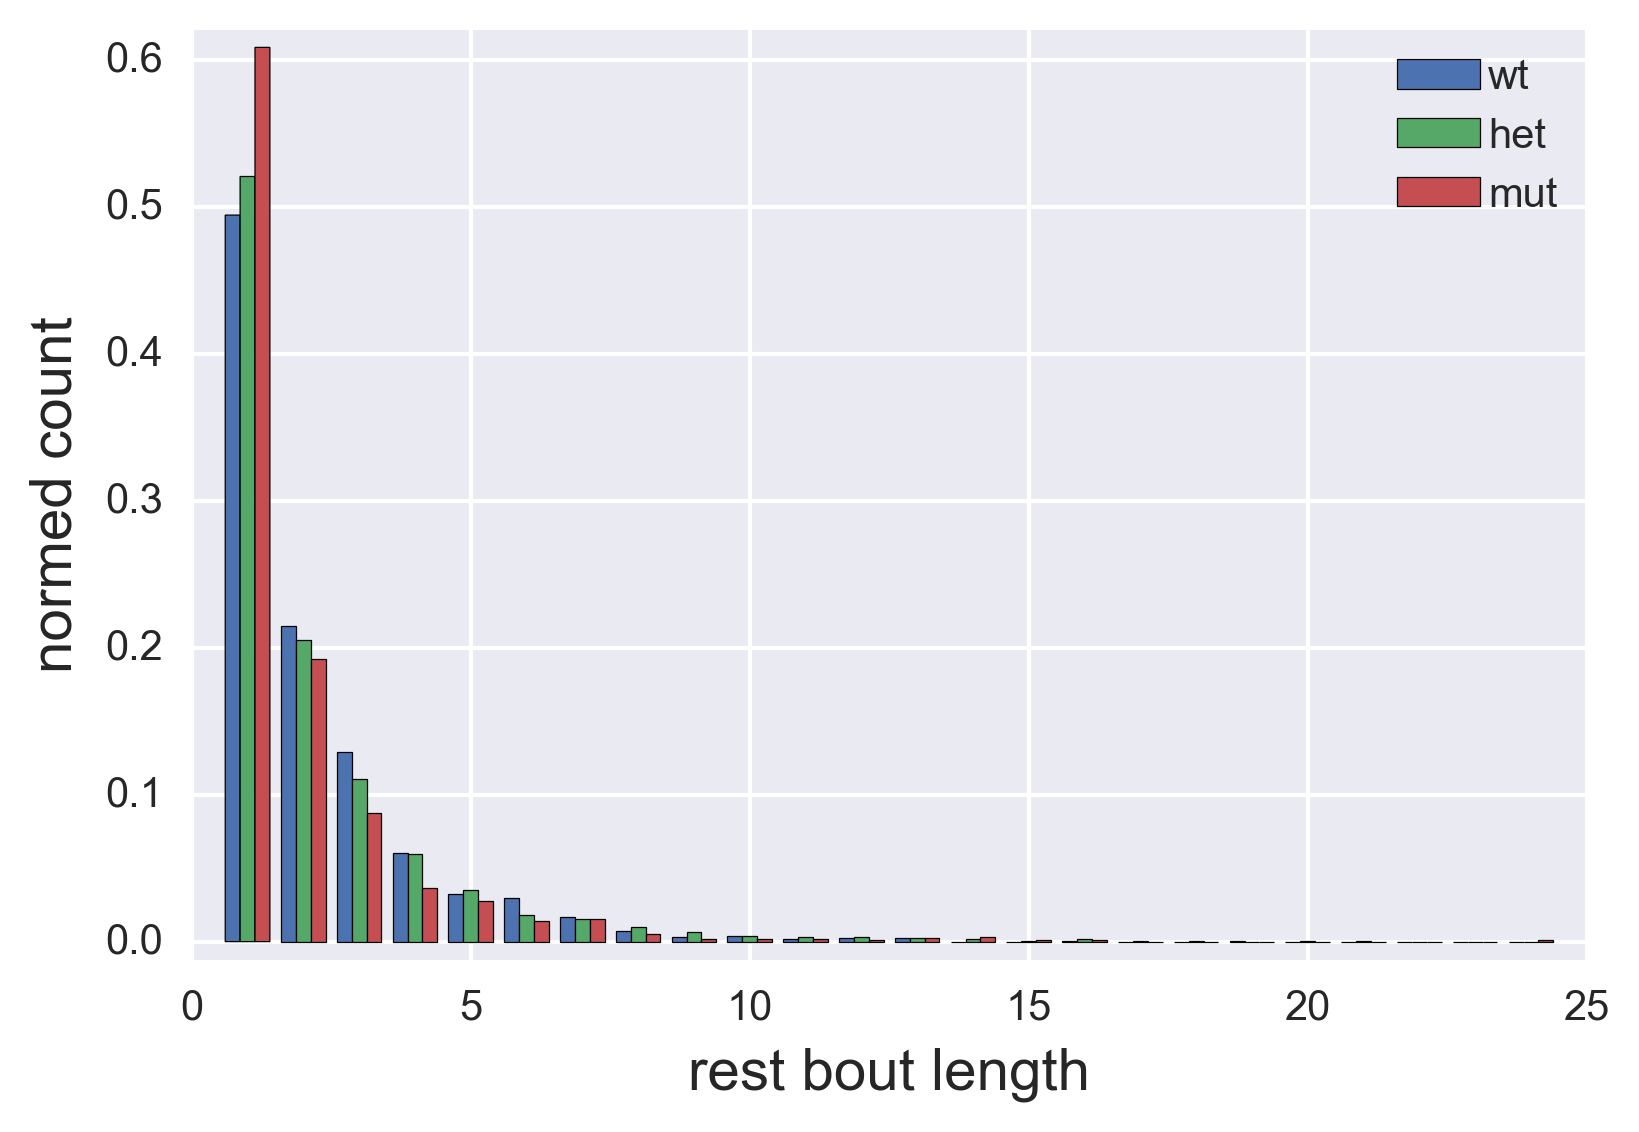

In [60]:
# Find maximal bout length
max_bout = np.concatenate((wt_bouts, het_bouts, mut_bouts)).max()

# Set up bins
bins = np.arange(0.5, max_bout + 1.5)

# Plot the histograms
_ = plt.hist([wt_bouts, het_bouts, mut_bouts], bins=bins, align='mid', 
             normed=True)
plt.margins(y=0.02)

# Labels and legend
plt.legend(['wt', 'het', 'mut'], loc='upper right')
plt.xlabel('rest bout length')
plt.ylabel('normed count');

We see that the mutant has more one-minute rest bouts and fewer longer ones.  We can also generate a cumulative histogram to show this effect.

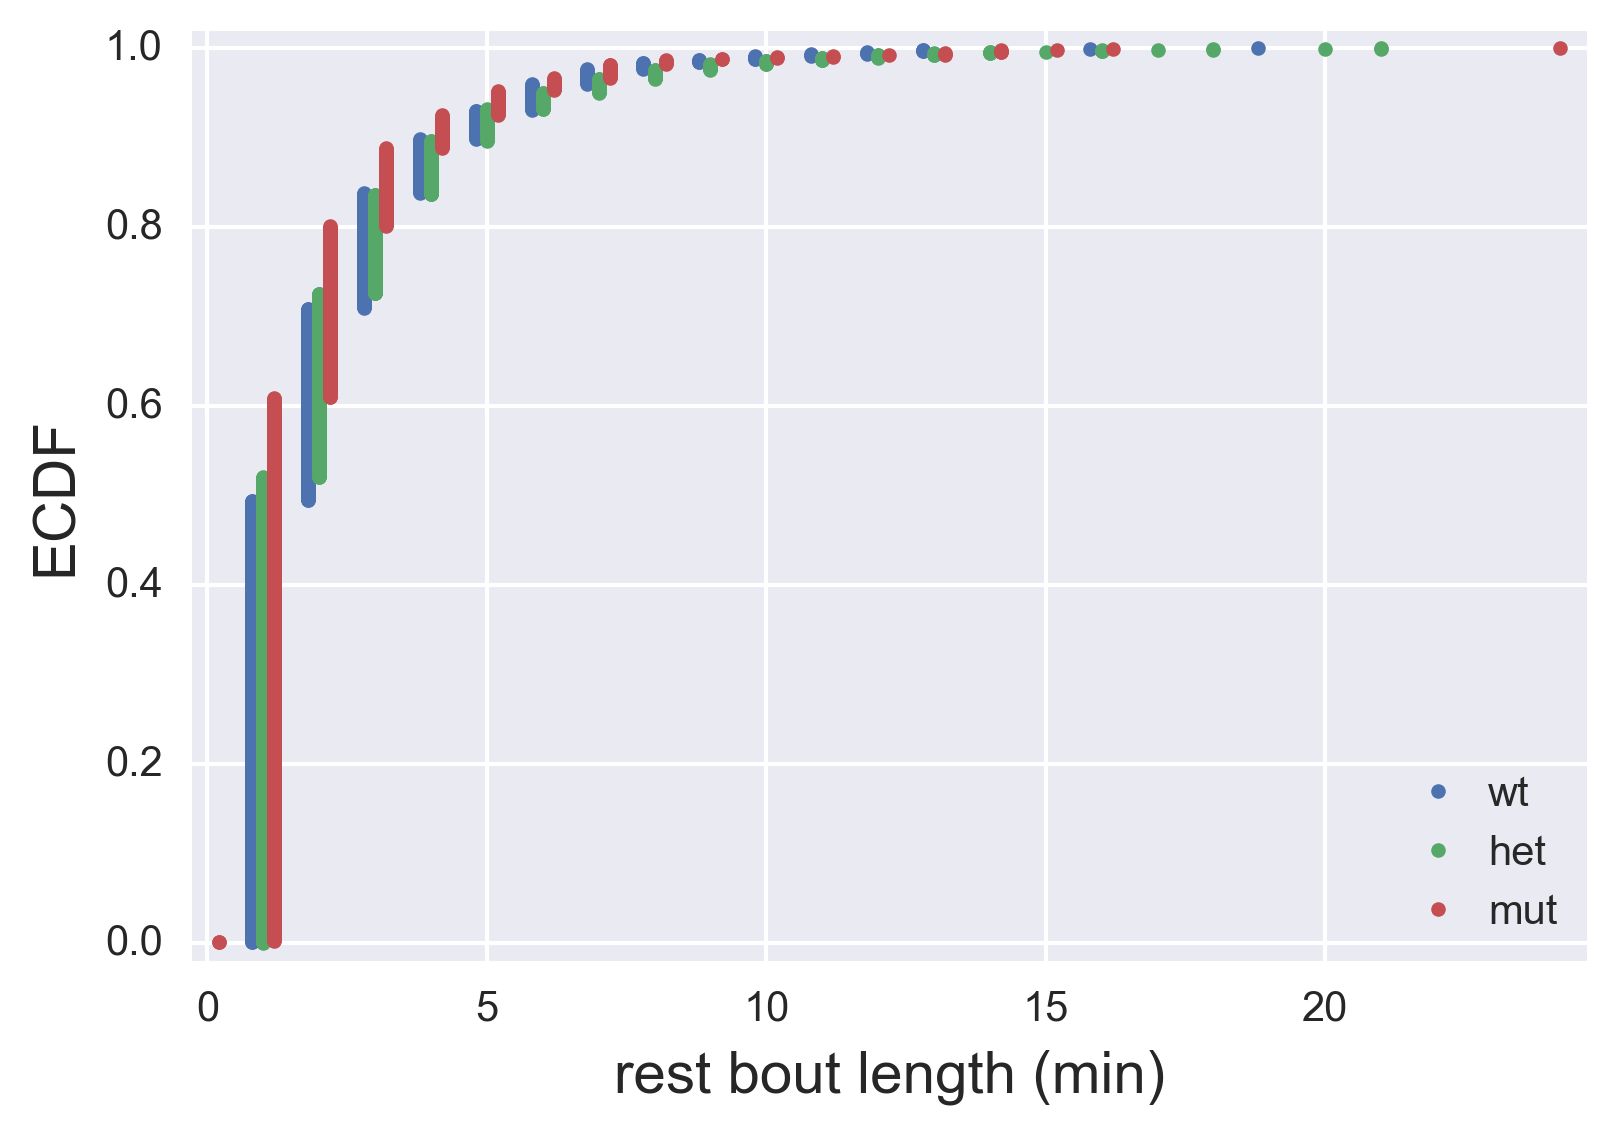

In [61]:
def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

# Generate x-values for each (with staggering)
x_wt, y_wt = ecdf(wt_bouts)
x_het, y_het = ecdf(het_bouts)
x_mut, y_mut = ecdf(mut_bouts)

# Plot cumulative hists with staggering
plt.plot(x_wt-0.2, y_wt, '.')
plt.plot(x_het, y_het, '.')
plt.plot(x_mut+0.2, y_mut, '.')
plt.margins(0.02)

# Labels and legend
plt.legend(['wt', 'het', 'mut'], loc='lower right')
plt.xlabel('rest bout length (min)')
plt.ylabel('ECDF');

Taking this approach reveals an important modeling concept.  We are trying to define *parameters* to describe fish sleep.  A parametric approach requires a model.  What would be our model for sleep bouts?  One possibility is that exit from a bout of rest is a Poisson process.  Then, we would expect the distribution of sleep bout lengths to be exponentially distributed (as we will learn in the lecture about probability distributions and their meanings).  In this case, the mean of the rest bouts has a physical meaning: it is the characteristic time for exit of a rest bout.  We would then want to see if the rest bouts are indeed exponentially distributed.

A problem with this approach is that the mean sleep bout for mutant fish is about two minutes, as we saw in [Tutorial 2b](../tutorials/t2b_defining_and_estimating_parameters.html).  This means that there are most likely many rest bouts that are shorter than one minute.  We would need to have access to higher-frequency data to assess this.  These data are available from the instrument used to do the measurement, and we could perform the analysis to investigate how sleep bouts are distributed.

We might also look at active bouts.  The analysis is analogous.  We start by computing the active bout lengths and storing them in a tidy `DataFrame` as we did in [Tutorial 2b](../tutorials/t2b_defining_and_estimating_parameters.html).

In [62]:
# Set up an empty DataFrame with the columns we want.
df_active_bout = pd.DataFrame(columns=['fish', 'genotype', 'active_bout_length'])

# Loop through each fish, construct array or active bouts, add to DataFrame
for fish in df_dense['fish'].unique():
    # Determine genotype of fish
    genotype = df_genotype.loc[df_genotype['fish']==fish, 'genotype'].values[0]

    # Indices of DataFrame to slice out
    inds = (~df_dense.light) & (df_dense.day==2) & (df_dense['fish']==fish)

    # Compute the active bouts
    active_bouts = bout_lengths(df_dense.loc[inds, 'activity'], rest=False)

    # Construct DataFrame of active bouts to add to full DataFrame
    if len(active_bouts) > 0:
        new_df = pd.DataFrame(data={'fish': [fish]*len(active_bouts),
                                    'genotype': [genotype]*len(active_bouts),
                                    'active_bout_length': active_bouts})
    else:
        new_df = pd.DataFrame(data={'fish': [fish],
                                    'genotype': [genotype],
                                    'active_bout_length': [np.nan]})        

    # Put new results in DataFrame
    df_active_bout = df_active_bout.append(new_df, ignore_index=True)
    
# Convert float fish ID to int
df_active_bout['fish'] = df_active_bout['fish'].astype(int)

# Pull out wild type, heterozygous, and mutant bouts as NumPy arrays
wt_bouts = df_active_bout.loc[df_active_bout['genotype']=='wt',
                            'active_bout_length'].fillna(0.0).values
het_bouts = df_active_bout.loc[df_active_bout['genotype']=='het',
                             'active_bout_length'].fillna(0.0).values
mut_bouts = df_active_bout.loc[df_active_bout['genotype']=='mut',
                             'active_bout_length'].fillna(0.0).values

Now, we again compute and plot the cumulative histograms.

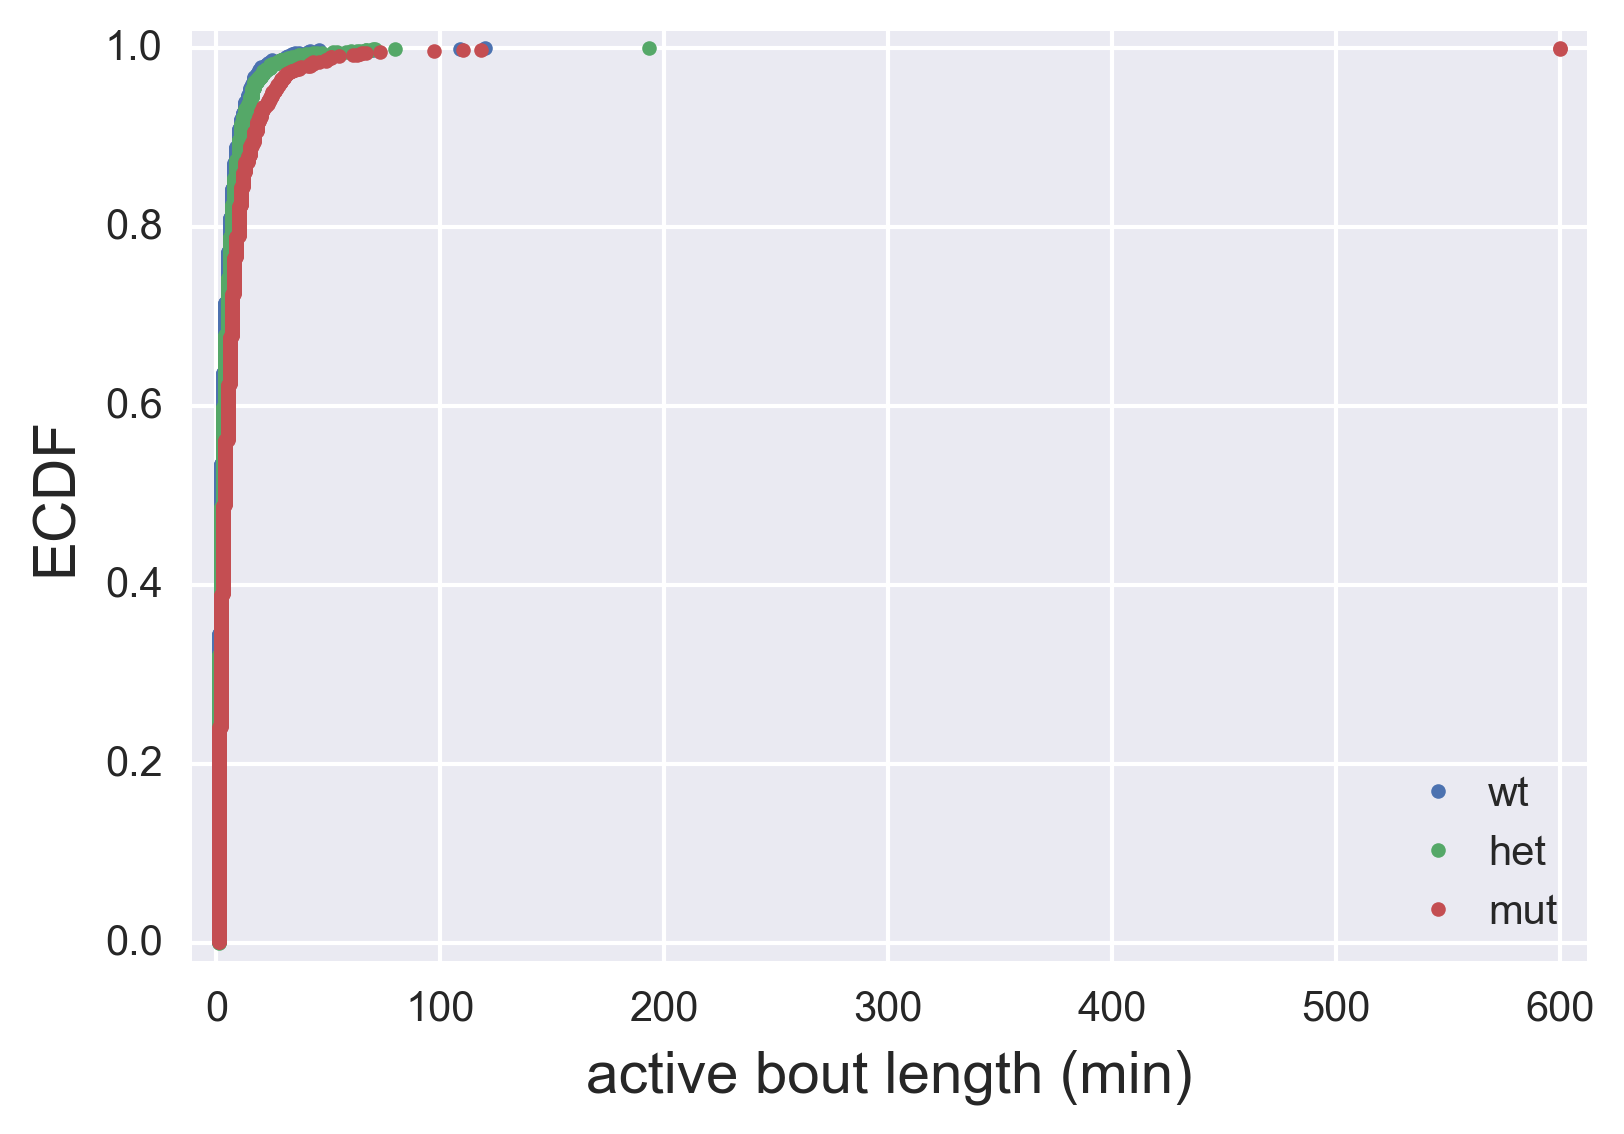

In [63]:
# Generate x-values for each (with staggering)
x_wt, y_wt = ecdf(wt_bouts)
x_het, y_het = ecdf(het_bouts)
x_mut, y_mut = ecdf(mut_bouts)

# Plot cumulative hists with staggering
plt.plot(x_wt, y_wt, '.')
plt.plot(x_het, y_het, '.')
plt.plot(x_mut, y_mut, '.')
plt.margins(0.02)

# Labels and legend
plt.legend(['wt', 'het', 'mut'], loc='lower right')
plt.xlabel('active bout length (min)')
plt.ylabel('ECDF');

The presence of very long active bouts (again, likely because we do not sample at low enough frequency to capture short rest bouts that would interrupt these long active bouts), makes the plot harder to read, so we can change the axis limits.

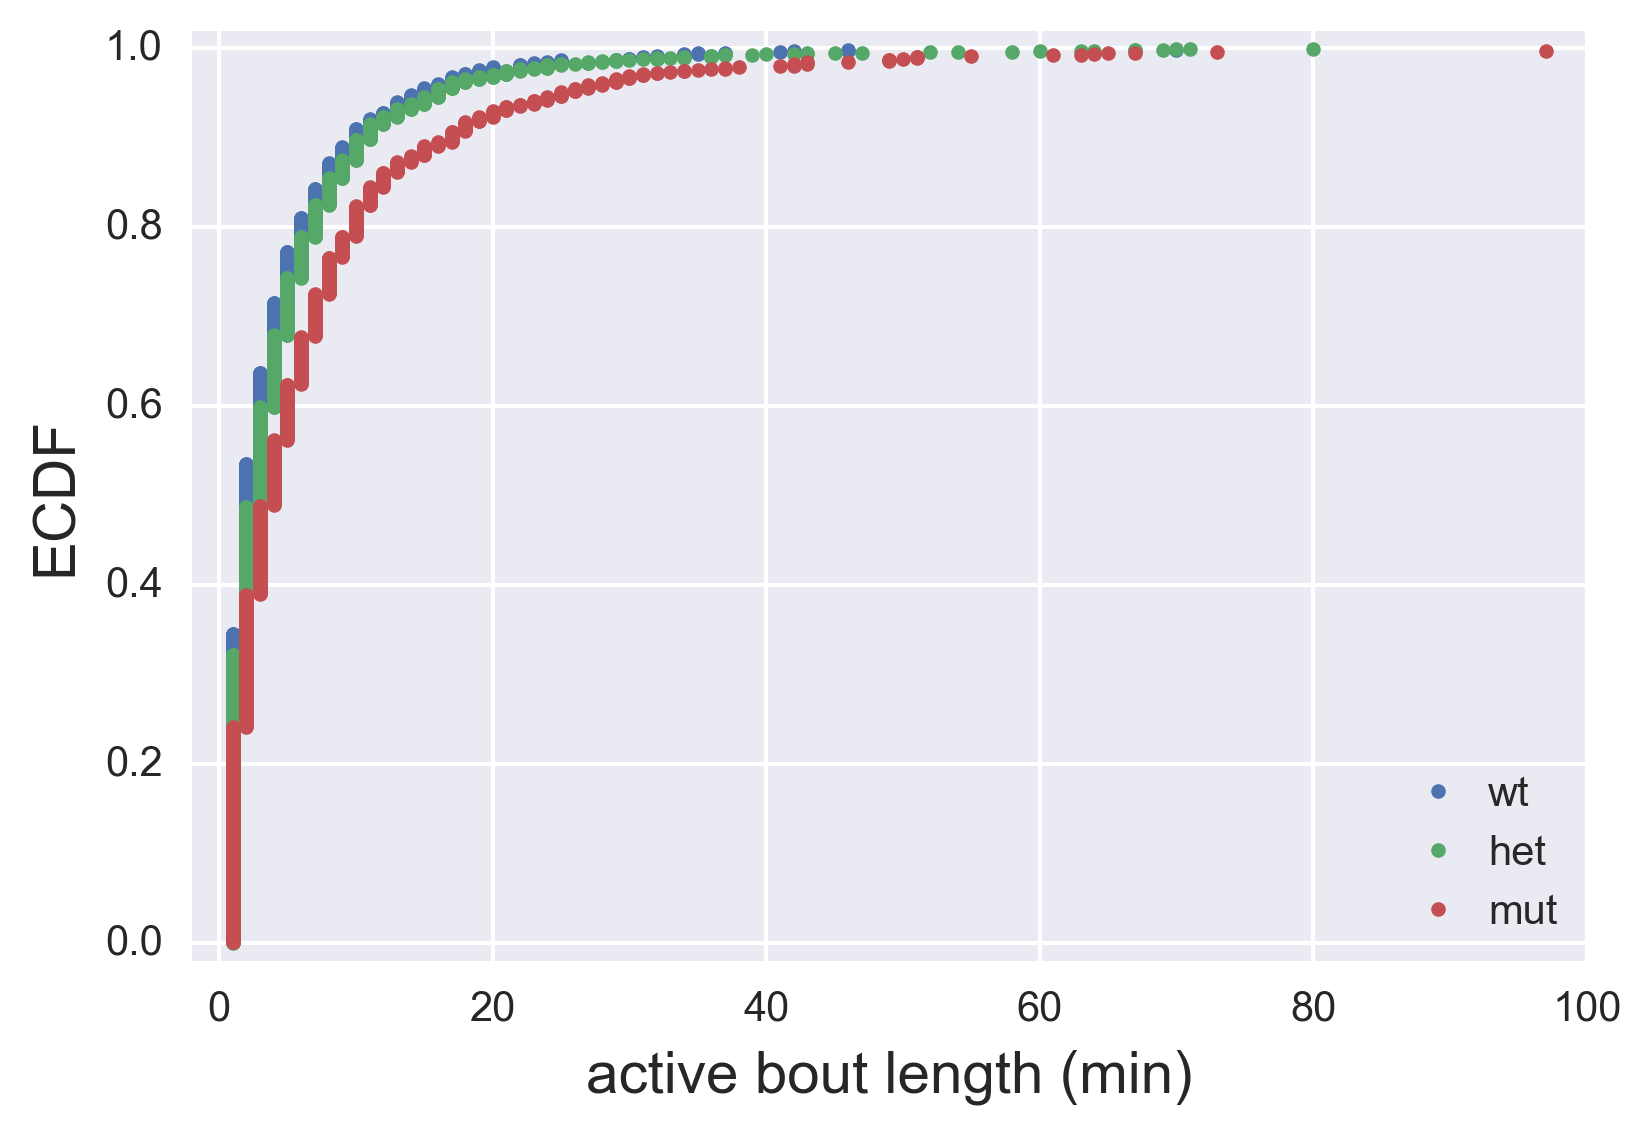

In [64]:
# Plot cumulative hists
plt.plot(x_wt, y_wt, '.')
plt.plot(x_het, y_het, '.')
plt.plot(x_mut, y_mut, '.')
plt.margins(y=0.02)
plt.xlim((-2, 100))

# Labels and legend
plt.legend(['wt', 'het', 'mut'], loc='lower right')
plt.xlabel('active bout length (min)')
plt.ylabel('ECDF')

Here, the presence of longer active bouts is pronounced in the homozygous mutants.  Heterozygous mutants also show very slightly longer active bouts than wild type, and a propensity for having quite long active bouts (again, possibly an artifact of the low-frequency sampling).

We can perform parameter estimation on these active bout lengths.  If we assume that the bout lengths are exponentially distributed, we can compute the posterior distribution of the average bout length for a given genotype, $\lambda$.  We take $\lambda$ to have a Jeffreys prior, $P(\lambda \mid I) \propto \lambda^{-1}$.  We assume each active bout is independent of all others, so the likelihood is

\begin{align}
P(D\mid \lambda, I) = \prod_{i\in D} \frac{1}{\lambda} \,\mathrm{e}^{-\tau_i/\lambda}
= \frac{1}{\lambda^{n+1}}\,\exp\left\{-\frac{1}{\lambda}\sum_{i\in D} \tau_i\right\},
\end{align}

where $\tau_i$ is the length of bout $i$.  So, the posterior is

\begin{align}
P(\lambda \mid D, I) \propto \frac{1}{\lambda^{n+1}}\,\exp\left\{-\frac{1}{\lambda}\sum_{i\in D} \tau_i\right\}.
\end{align}

We can do some macho integration to compute the normalization constant, which gives

\begin{align}
P(\lambda \mid D, I) = \frac{T^n}{(n-1)!\,\lambda^{n+1}}\,\mathrm{e}^{-T/\lambda},
\end{align}

where

\begin{align}
T = \sum_{i\in D} \tau_i.
\end{align}

We can make plots of the posterior for each of the genotypes.

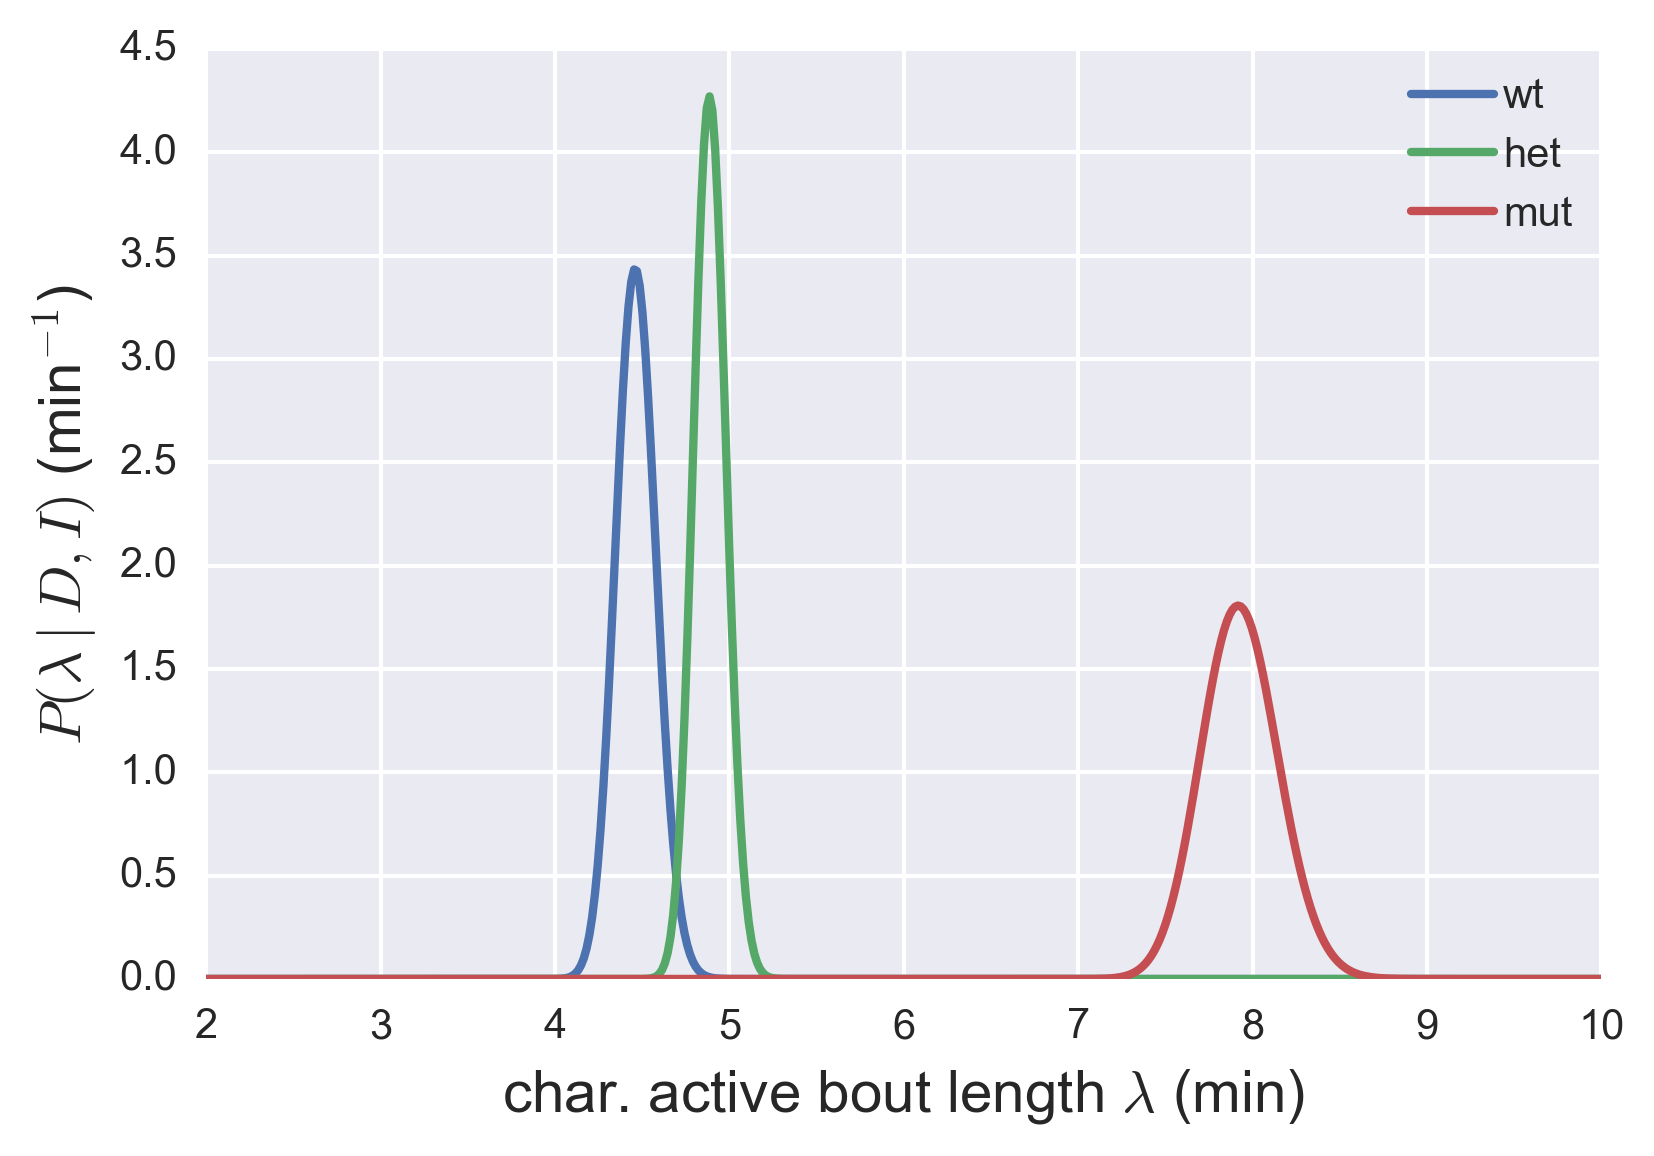

In [65]:
def posterior(active_bouts, lam):
    """
    Compute posterior for pooled active bout times.
    """
    T = active_bouts.sum()
    n = len(active_bouts)
    
    log_P = n * np.log(T) - (n + 1) * np.log(lam) - scipy.special.gammaln(n) \
                    - T / lam
    return np.exp(log_P)

# Lambda values for plotting
lam = np.linspace(2, 10, 500)

# Compute posteriors
post_wt = posterior(wt_abouts, lam)
post_het = posterior(het_abouts, lam)
post_mut = posterior(mut_abouts, lam)

# Plot results
plt.plot(lam, post_wt)
plt.plot(lam, post_het)
plt.plot(lam, post_mut)

# Labels
plt.xlabel(r'char. active bout length $\lambda$ (min)')
plt.ylabel(r'$P(\lambda \mid D, I)$ (min$^{-1}$)')
plt.legend(['wt', 'het', 'mut'], loc='upper right')

The posterior distribution show that the mutant has a higher active bout length be nearly a factor of two from wild type or heterozygous mutants.  The heterozygous mutant is also likely to have longer active bouts than wild type, though the effect is small.  As a final instructive plot, we can overlay the most likely distribution and the ECDF.

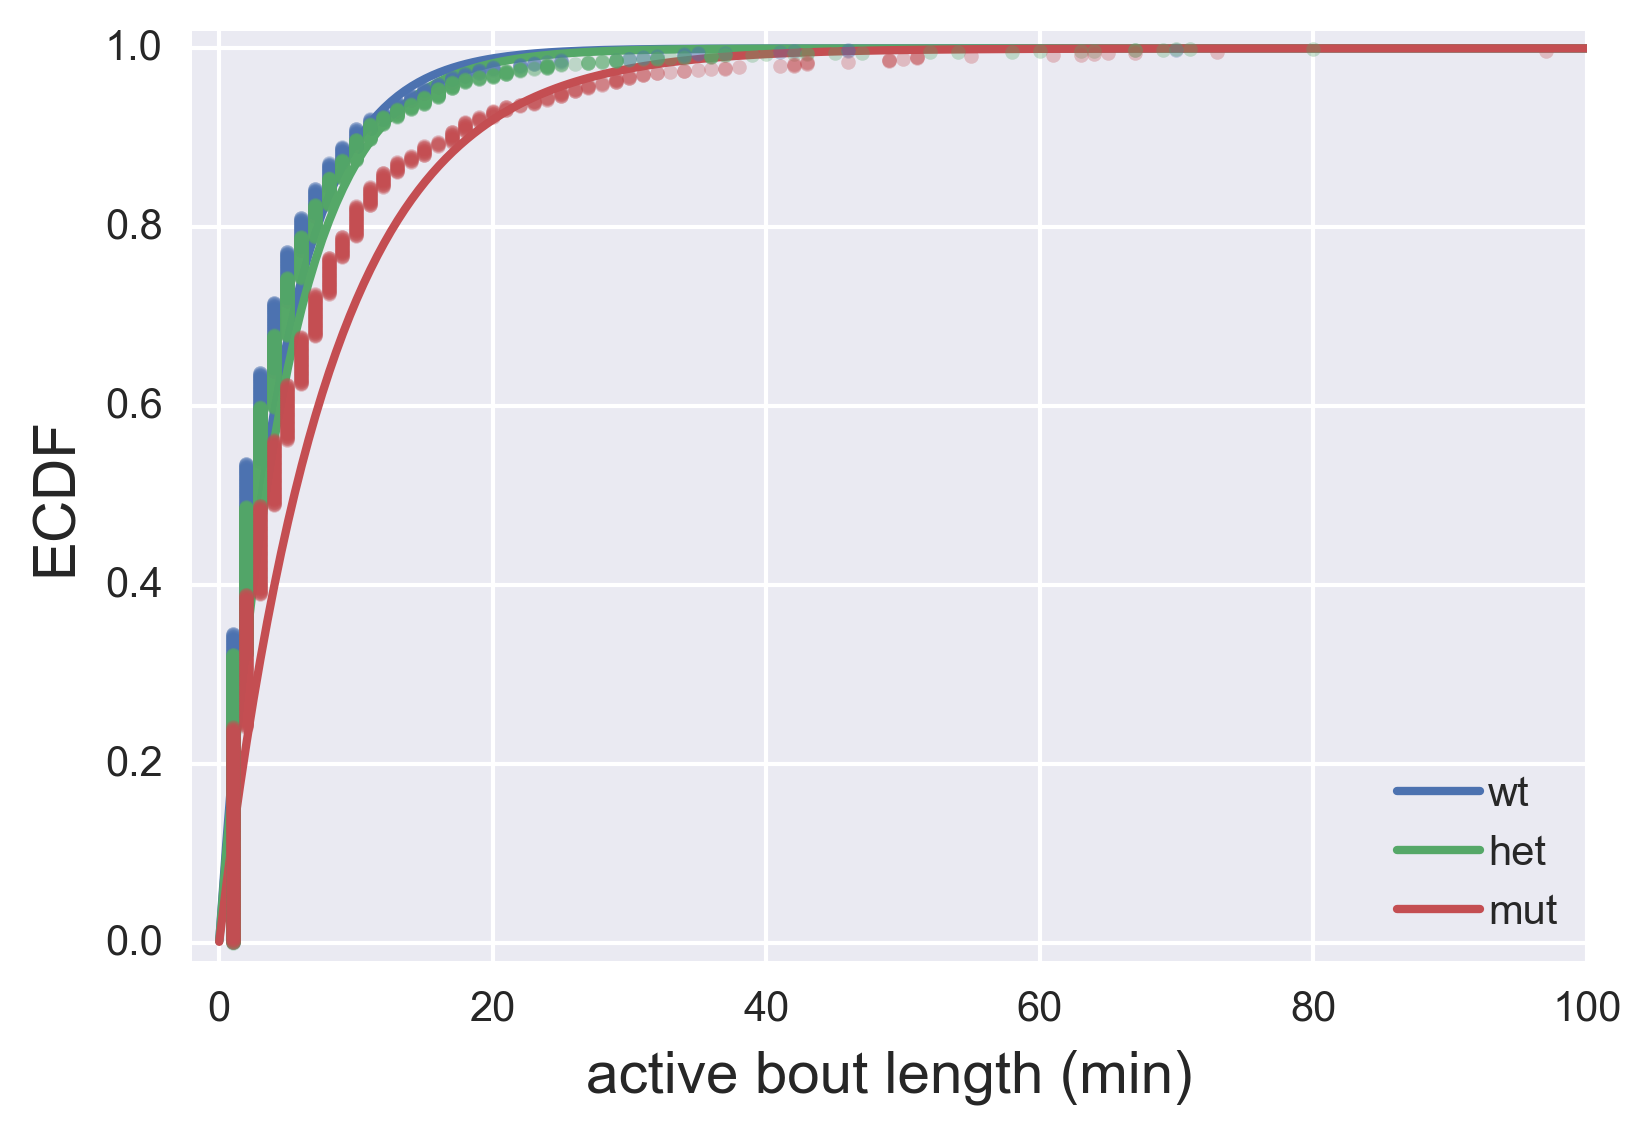

In [67]:
# Get approximate most likely lambda values
wt_lam = lam[np.argmax(post_wt)]
het_lam = lam[np.argmax(post_het)]
mut_lam = lam[np.argmax(post_mut)]

# Plot theoretical curves
x = np.linspace(0.01, 100, 200)
plt.plot(x, 1 - np.exp(-x / wt_lam), '-', color=sns.color_palette()[0])
plt.plot(x, 1 - np.exp(-x / het_lam), '-', color=sns.color_palette()[1])
plt.plot(x, 1 - np.exp(-x / mut_lam), '-', color=sns.color_palette()[2])

# Plot cumulative hists
plt.plot(x_wt, y_wt, '.', alpha=0.3)
plt.plot(x_het, y_het, '.', alpha=0.3)
plt.plot(x_mut, y_mut, '.', alpha=0.3)

# Tidy up
plt.margins(y=0.02)
plt.xlim((-2, 100))
plt.legend(['wt', 'het', 'mut'], loc='lower right')
plt.xlabel('active bout length (min)')
plt.ylabel('ECDF');

From the plot, we see that the pooled data are likely not exponentially distributed, which calls our model into question.  Nonetheless, without parameterizing and simply comparing the ECDFs, we still see a striking difference between the wild type and the homozygous mutant.  We will revisit this data set in future problem sets to attempt to find a better model.

<br />
<br />